# Content based recommendation - Clustering

This notebook contains the pre processing part for the optimal base to cluster the data.

To find the best amount of cluster the Elbow method is used.
The elbow point is the value of k where the WCSS curve begins to flatten. It represents the point at which adding more clusters leads to diminishing returns in reducing WCSS.

For comparison the Silhouette analysis was also performed.
Silhouette analysis is a method to evaluate the quality of clustering by measuring how well each data point lies within its cluster compared to other clusters. It provides a single score (the silhouette score) for each data point, which can then be averaged to evaluate the overall quality of the clustering.

After that the clustering starts with the hierarchical Clustering with Dendrogram.
The next cluster method was KMeans. First implemented with PCA and then visualized with t-SNE transformation.

The last Cluster method was the DBSCAN Clustering.

At the end of the notebook the KMeans cluster result is used to recommend a user the top 10 articles within the user's top cluster. Teh recommended articles are only articles that the user has not read so far.

# Imports and Preparing the data of behavior.tsv and news.tsv #

In [ ]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import silhouette_score
import numpy as np
import pandas as pd
import re
from pathlib import Path
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack
from sklearn.decomposition import IncrementalPCA, PCA
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
from wordcloud import WordCloud
from collections import defaultdict


# Load the data
base_path = Path.cwd() / 'data'
news_path = base_path / 'news.tsv'
behaviors_path = base_path / 'behaviors.tsv'

news = pd.read_csv(news_path, sep='\t', names=['news_id', 'category', 'subcategory', 'title', 'abstract', 'url', 'title_entities', 'abstract_entities'])
behaviors = pd.read_csv(behaviors_path, sep='\t', names=['impression_id', 'user_id', 'time', 'history', 'impressions'])

# Preprocessing with Data Cleaning Remove duplicates and Text cleaning

In [2]:
# Data Cleaning
# Check if attributes such as Category, Subcategory, Title, and Abstract in news.tsv are complete.
# Remove news items with many missing values or replace them with:
# Category: unknown
# Subcategory: general
# Title and Abstract: a placeholder text like "Missing Data."
# For behaviors.tsv, remove users with missing or empty history.
news.fillna({'category': 'unknown', 'subcategory': 'general', 'title': 'Missing Title', 'abstract': 'Missing Abstract'}, inplace=True)
news.dropna(subset=['category', 'subcategory', 'title', 'abstract'], inplace=True)
behaviors.dropna(subset=['history', 'impressions'], inplace=True)

# Count duplicates before removing them
news_duplicates_before = len(news) - len(news.drop_duplicates(subset=['title', 'abstract']))
behaviors_duplicates_before = len(behaviors) - len(behaviors.drop_duplicates(subset=['impression_id']))


# Remove duplicates
# Remove news items in news.tsv that have the same values for Title and Abstract.
# Remove duplicate impressions (Impression ID) in behaviors.tsv
news.drop_duplicates(subset=['title', 'abstract'], inplace=True)
behaviors.drop_duplicates(subset=['impression_id'], inplace=True)

# Count duplicates after removing them (should be zero)
news_duplicates_after = len(news) - len(news.drop_duplicates(subset=['title', 'abstract']))
behaviors_duplicates_after = len(behaviors) - len(behaviors.drop_duplicates(subset=['impression_id']))

# Print the results
print(f"Removed {news_duplicates_before} duplicate news articles.")
print(f"Removed {behaviors_duplicates_before} duplicate impressions.")
print(f"Remaining duplicate news articles after cleaning: {news_duplicates_after}.")
print(f"Remaining duplicate impressions after cleaning: {behaviors_duplicates_after}.")

Removed 613 duplicate news articles.
Removed 0 duplicate impressions.
Remaining duplicate news articles after cleaning: 0.
Remaining duplicate impressions after cleaning: 0.


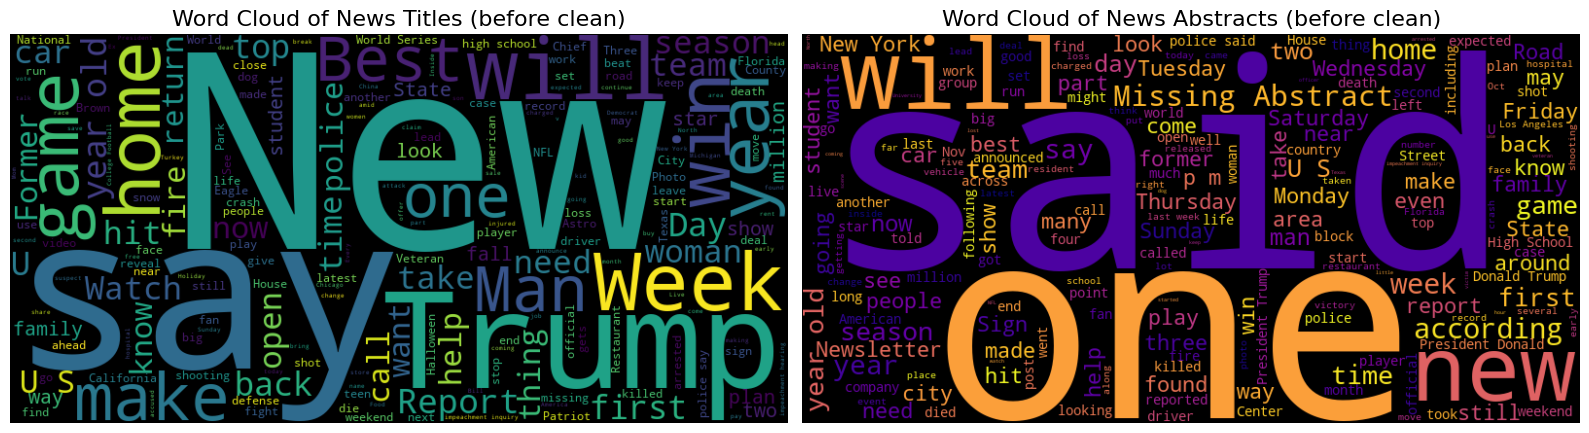

In [3]:
# Erstelle einen String aus den bereinigten Titeln
title_text = " ".join(news['title'])
abstract_text = " ".join(news['abstract'])

# Generiere die Word Cloud für Titel
title_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis').generate(title_text)

# Generiere die Word Cloud für Abstracts
abstract_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='plasma').generate(abstract_text)

# Darstellung der Word Clouds
plt.figure(figsize=(16, 8))

# Word Cloud für Titel
plt.subplot(1, 2, 1)
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of News Titles (before clean)", fontsize=16)

# Word Cloud für Abstracts
plt.subplot(1, 2, 2)
plt.imshow(abstract_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of News Abstracts (before clean)", fontsize=16)

plt.tight_layout()
plt.show()

In [4]:
# Text cleaning
# Break down Title and Abstract into tokens:
# Remove special characters, numbers, and HTML.
# Convert all words to lowercase.
# Remove stopwords (e.g., using nltk or spacy).
# Perform lemmatization to reduce words to their base form.
def clean_text(text):
    # Clean text by removing special characters, numbers, and converting to lowercase
    text = re.sub(r"n't", " not", text)
    text = re.sub(r"'ll", " will", text)
    text = re.sub(r"'ve", " have", text)
    text = re.sub(r"'re", " are", text)
    text = re.sub(r"'d", " would", text)
    text = re.sub(r"'s", " is", text)
    
    # Remove special characters
    text = re.sub(r'\W+', ' ', text)
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    text = re.sub(r'\d+', '<NUMBER>', text)
    return text.lower()

def remove_stopwords_and_lemmatize(text):
    # Remove stopwords and perform basic stemming/lemmatization
    stopwords = set([
    'the', 'and', 'is', 'in', 'to', 'of', 'a', 'an', 'on', 'for', 'with', 'as', 'by', 'at', 'from', 'this', 'that', 'it', 'or', 'but', 'not', 'be', 'are', 'was', 'were', 'can', 'will', 'would', 'should', 'has', 'have', 'had', 'do', 'does', 'did', 'which', 'if', 'then', 'than', 'so', 'such', 'there', 'about', 'into', 'over',
    'after', 'abc', 'accord', 'news', 'report', 'release', 'authoriti', 'people', 'act', 'aft', 'add', 'new', 'after','appear', 'he', 'she', 'they', 'we', 'you', 'i', 'his', 'her', 'their', 'its', 'ours', 'theirs', 'your', 'my', 'mine', 'ourselves', 'yourselves', 'has', 'had', 'have', 'having', 'be', 'is', 'am', 'are', 'was', 'were', 'will', 'would', 'can', 'could', 'shall', 'should', 'might', 'must', 'do', 'does', 'did', 'doing', 'done', 'doesn’t', 'didn’t', 'above', 'below', 'between', 'under', 'within', 'against', 'during', 'before', 'after', 'under', 'among', 'throughout', 'along', 'around', 'across', 'besides', 'towards', 'despite', 'except', 'as', 'like', 'by', 'nor', 'because', 'until', 'while', 'on', 'off', 'up', 'down', 'over', 'under', 'with', 'without', 'very', 'really', 'just', 'quite', 'more', 'less', 'only', 'already', 'still', 'even', 'never', 'always', 'sometimes', 'usually', 'likely', 'so', 'however', 'therefore', 'too', 'then', 'instead', 'almost', 'again', 'further', 'also', 'together', 'finally', 'actually', 'necessarily', 'let', 'let’s', 'might', 'may', 'must', 'ought', 'shall', 'should', 'could', 'would', 'can', 'can\'t', 'didn\'t', 'don\'t', 'doesn\'t', 'wasn\'t', 'weren\'t', 'won\'t', 'didn\'t', 'cnn', 'bbc', 'apple', 'microsoft', 'google', 'amazon', 'twitter', 'facebook', 'microsoft', 'tesla', 'elon', 'johnson', 'clinton', 'trump', 'obama', 'biden', 'eu', 'un', 'nato', 'fifa', 'nba', 'mlb', 'spacex', 'said', 'says', 'states', 'reported', 'reports', 'released', 'reveals', 'discusses', 'confirmed', 'announced', 'according', 'according to', 'statement', 'revealed', 'details', 'claim', 'claims', 'said', 'said to', 'called', 'describes', 'explained', 'just', 'basically', 'literally', 'actually', 'seriously', 'absolutely', 'completely', 'totally', 'clearly', 'evidently', 'definitely', 'pretty', 'exactly', 'day', 'week', 'month', 'year', 'time', 'morning', 'evening', 'night', 'today', 'tomorrow', 'yesterday', 'hour', 'minute', 'second', 'one', 'two', 'three', 'four', 'five', 'hundred', 'thousand', 'million', 'billion', 'percent', 'kg', 'm', 'cm', 'inch', 'km', 'g', 'url', 'www', 'http', 'https', 'www', 'doc', 'pdf', 'jpg', 'jpeg', 'png', 'mp3', 'zip', 'ppt', 'xls', 'fact', 'such', 'as', 'in', 'even', 'case', 'of', 'with',
    # Add words from clusters
    'afc', 'north', 'south', 'aaron', 'rodger', 'adam', 'gase', 'angel', 'lakers', 'alex', 'bregman', 'alexandria', 'ocasio',  'rams', 'al', 'baghdadi', 'ukraine', 'ambassador', 'action', 'afternoon','age', 'admitt', 'addition', 'agency', 'ag', 'advance', 'academy', 'additional', 'aid', 'ago',  'affect', 'afford', 'active', 'accept', 'accus', 'agre', 'advis', 'account', 'access', 'abstract', 'adults',  'adult', 'advisory', 'abandon', 'accident', 'america', 'address', 'administration', 'acr', 'ahead', 'alleged',  'airlin', 'allen', 'abuse', 'activity', 'actors', 'actress', 'agents', 'agreement', 'alarm', 'alexand', 'andy',   'alleged', 'answers', 'actor', 'allow', 'administration', 'agency', 'al', 'air', 'aim', 'alert', 'aid', 'home', 'win', 'u', 'miss', 'go', 'team', 'monday', 'tuesday', 'first', 'last', 'man', 'top', 'back', 'best', 'open', 'us', 'wednesday', 'play', 'thursday', 'sign', 'sunday', 'now', 'start', 'look', 'season', 'game', 'watch', 'want', 's', 'make', 'old', 'friday', 'saturday', 'woman'
])

    
    def advanced_lemmatization(word):
        # Remove common suffixes like 'ed', 'ing', 'es', 'er', 'ly'
        suffixes = ['ed', 'ing', 'es', 'er', 'ly', 'able', 'ness']
        for suffix in suffixes:
            if word.endswith(suffix):
                return word[:-len(suffix)]
        return word

    # List of simple verbs
    irregular_verbs = {
        'ran': 'run',
        'ate': 'eat',
        'wrote': 'write',
        'went': 'go',
        'saw': 'see',
        'had': 'have',
        'was': 'be',
        'were': 'be'
    }

    def lemmatize_irregular_verbs(word):
        return irregular_verbs.get(word, word)

    words = text.split()
    lemmatized = []

    for word in words:
        if word.lower() not in stopwords:
            # Outsort verbs
            word = lemmatize_irregular_verbs(word)
            # Remove suffix
            word = advanced_lemmatization(word)
            lemmatized.append(word)

    return " ".join(word for word in lemmatized if word not in stopwords)

def preprocess_text(text):
    # Full preprocessing pipeline: clean text, remove stopwords, and lemmatize
    cleaned_text = clean_text(text)
    return remove_stopwords_and_lemmatize(cleaned_text)


def preprocess_text_parallel(texts):
    processed_texts = [preprocess_text(text) for text in texts]
    return processed_texts


# Clean Title and Abstract
news['clean_title'] = preprocess_text_parallel(news['title'])
news['clean_abstract'] = preprocess_text_parallel(news['abstract'])

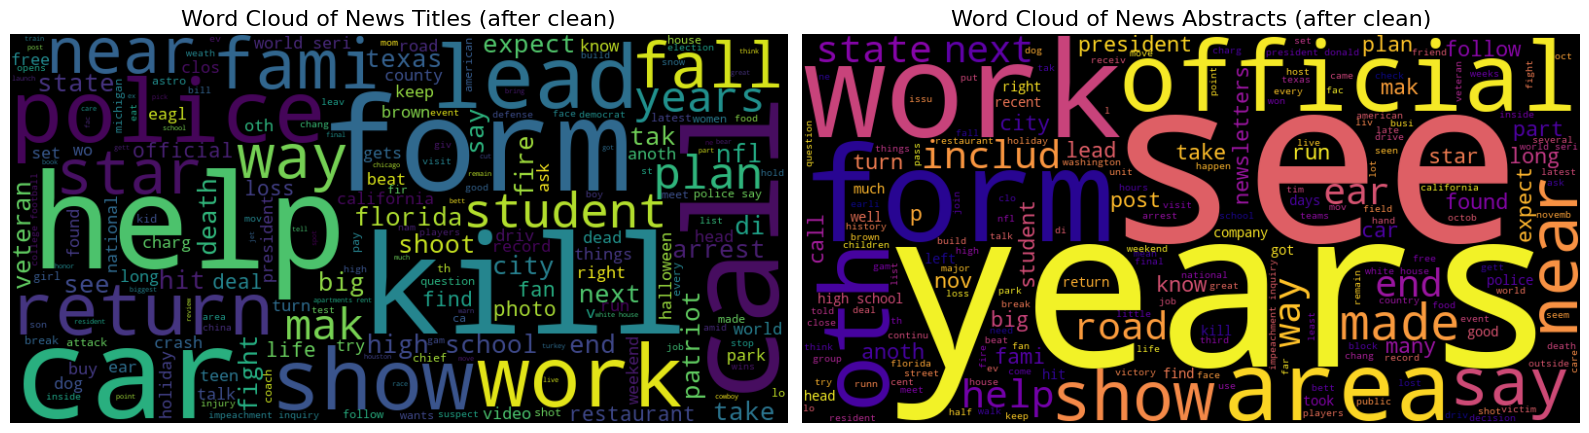

In [5]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Erstelle einen String aus den bereinigten Titeln
title_text = " ".join(news['clean_title'])
abstract_text = " ".join(news['clean_abstract'])

# Generiere die Word Cloud für Titel
title_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='viridis').generate(title_text)

# Generiere die Word Cloud für Abstracts
abstract_wordcloud = WordCloud(width=800, height=400, background_color='black', colormap='plasma').generate(abstract_text)

# Darstellung der Word Clouds
plt.figure(figsize=(16, 8))

# Word Cloud für Titel
plt.subplot(1, 2, 1)
plt.imshow(title_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of News Titles (after clean)", fontsize=16)

# Word Cloud für Abstracts
plt.subplot(1, 2, 2)
plt.imshow(abstract_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of News Abstracts (after clean)", fontsize=16)

plt.tight_layout()
plt.show()

# Data Preparation with TF-IDF, One-hot and PCA

max_features is 2000, so the shape for TF-IDF will be (50669, 2000).

The combined shape for title and abstract will be (50669, 4000) as there is 2000 for title and 2000 for abstract.

For category : (50669, 17) as 17 unique categories

For subcategory: (50669, 263) as 263 unique subcategories.

For the final combined: 4280 = 4000 + 17 + 263

Reduced with PCA : from 4280 to 100

In [6]:
# TF-IDF for clean_title
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=2000, stop_words='english')
tfidf_title = tfidf_vectorizer.fit_transform(news['clean_title'])

# Print dimensions after transforming titles
print(f"TF-IDF Title Shape: {tfidf_title.shape}")  # Number of titles x 2000 (max_features)

# TF-IDF for clean_abstract
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 1), max_features=2000, stop_words='english')
tfidf_abstract = tfidf_vectorizer.fit_transform(news['clean_abstract'])

# Print dimensions after transforming abstracts
print(f"TF-IDF Abstract Shape: {tfidf_abstract.shape}")  # Number of abstracts x 2000 (max_features)

# Combine sparse matrices (titles + abstracts)
news_features = hstack([tfidf_title, tfidf_abstract])
print(f"Combined TF-IDF Features Shape: {news_features.shape}")  # Number of items x 4000 (2000 + 2000)

# One-hot encode categories and subcategories
category_encoded = pd.get_dummies(news['category'])
subcategory_encoded = pd.get_dummies(news['subcategory'])

# Print dimensions of one-hot encoded features
print(f"Category Encoding Shape: {category_encoded.shape}")  # Number of items x unique categories
print(f"Subcategory Encoding Shape: {subcategory_encoded.shape}")  # Number of items x unique subcategories

# Combine all features (TF-IDF + category + subcategory)
final_features = hstack([news_features, category_encoded.values, subcategory_encoded.values])
print(f"Final Combined Features Shape: {final_features.shape}")  # Number of items x (4000 + categories + subcategories)

# PCA for dimensionality reduction
pca = IncrementalPCA(n_components=100, batch_size=1000)
reduced_features = pca.fit_transform(news_features)

# Print dimensions after PCA
print(f"Reduced Features Shape (after PCA): {reduced_features.shape}")  # Number of items x 100

TF-IDF Title Shape: (50669, 2000)
TF-IDF Abstract Shape: (50669, 2000)
Combined TF-IDF Features Shape: (50669, 4000)
Category Encoding Shape: (50669, 17)
Subcategory Encoding Shape: (50669, 263)
Final Combined Features Shape: (50669, 4280)
Reduced Features Shape (after PCA): (50669, 100)


# Elbow method to get best cluster amount

The elbow point is the value of k where the WCSS curve begins to flatten. It represents the point at which adding more clusters leads to diminishing returns in reducing WCSS.

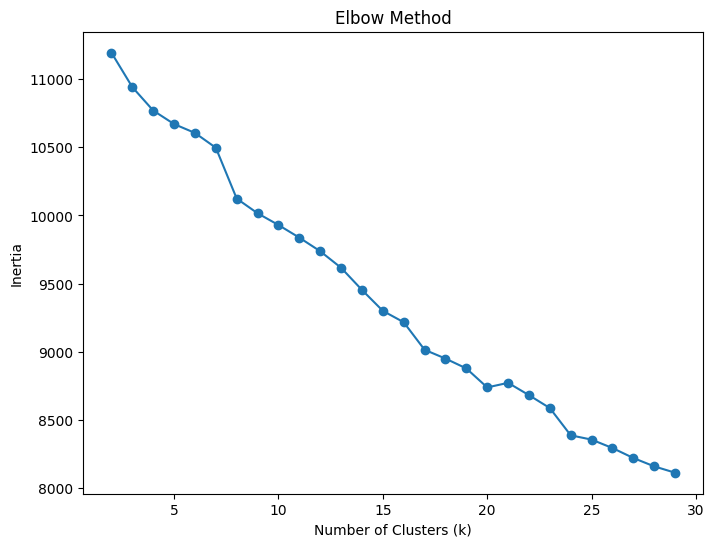

In [7]:
# Elbow method
inertia_values = []
cluster_range = range(2, 30)  # Test cluster numbers between 2 and 14

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(reduced_features)
    inertia_values.append(kmeans.inertia_)

# Elbow Method
plt.figure(figsize=(8, 6))
plt.plot(cluster_range, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method')
plt.show()

In [8]:
elbow_k = cluster_range[np.diff(np.sign(np.diff(inertia_values))).argmax() + 1]
print(f"Optimal number of clusters from Elbow method: {elbow_k}")

Optimal number of clusters from Elbow method: 20


# Silhouette analysis to get best cluster amount

Silhouette analysis is a method to evaluate the quality of clustering by measuring how well each data point lies within its cluster compared to other clusters. It provides a single score (the silhouette score) for each data point, which can then be averaged to evaluate the overall quality of the clustering.

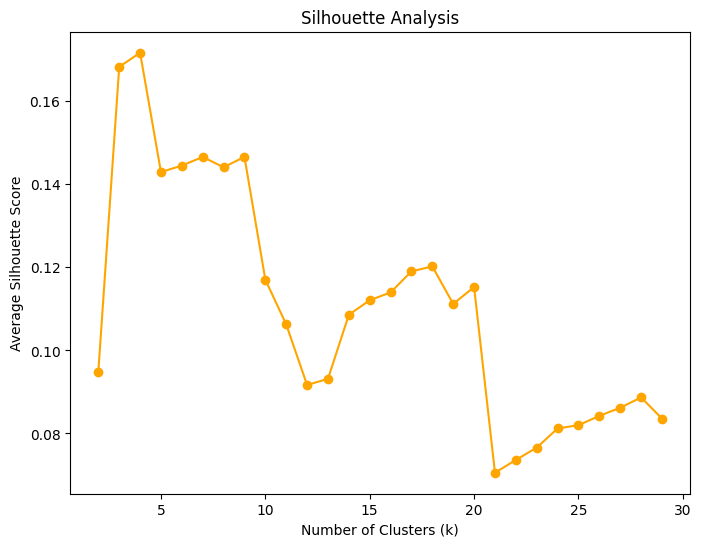

In [9]:
# Silhouette analysis
silhouette_scores = []

for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(reduced_features)
    silhouette_avg = silhouette_score(reduced_features, labels)
    silhouette_scores.append(silhouette_avg)

plt.figure(figsize=(8, 6))
plt.plot(cluster_range, silhouette_scores, marker='o', color='orange')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Analysis')
plt.show()

In [10]:
# Print the best k according to silhouette score
optimal_k_silhouette = cluster_range[np.argmax(silhouette_scores)]
print(f"Optimal number of clusters from Silhouette method: {optimal_k_silhouette}")

# Print average silhouette score for each k
for k, score in zip(cluster_range, silhouette_scores):
    print(f"Number of clusters: {k}, Average Silhouette Score: {score:.4f}")

Optimal number of clusters from Silhouette method: 4
Number of clusters: 2, Average Silhouette Score: 0.0949
Number of clusters: 3, Average Silhouette Score: 0.1683
Number of clusters: 4, Average Silhouette Score: 0.1717
Number of clusters: 5, Average Silhouette Score: 0.1430
Number of clusters: 6, Average Silhouette Score: 0.1445
Number of clusters: 7, Average Silhouette Score: 0.1466
Number of clusters: 8, Average Silhouette Score: 0.1441
Number of clusters: 9, Average Silhouette Score: 0.1466
Number of clusters: 10, Average Silhouette Score: 0.1170
Number of clusters: 11, Average Silhouette Score: 0.1063
Number of clusters: 12, Average Silhouette Score: 0.0917
Number of clusters: 13, Average Silhouette Score: 0.0932
Number of clusters: 14, Average Silhouette Score: 0.1086
Number of clusters: 15, Average Silhouette Score: 0.1121
Number of clusters: 16, Average Silhouette Score: 0.1140
Number of clusters: 17, Average Silhouette Score: 0.1190
Number of clusters: 18, Average Silhouette 

# Hierarchical Clustering with Dendrogram

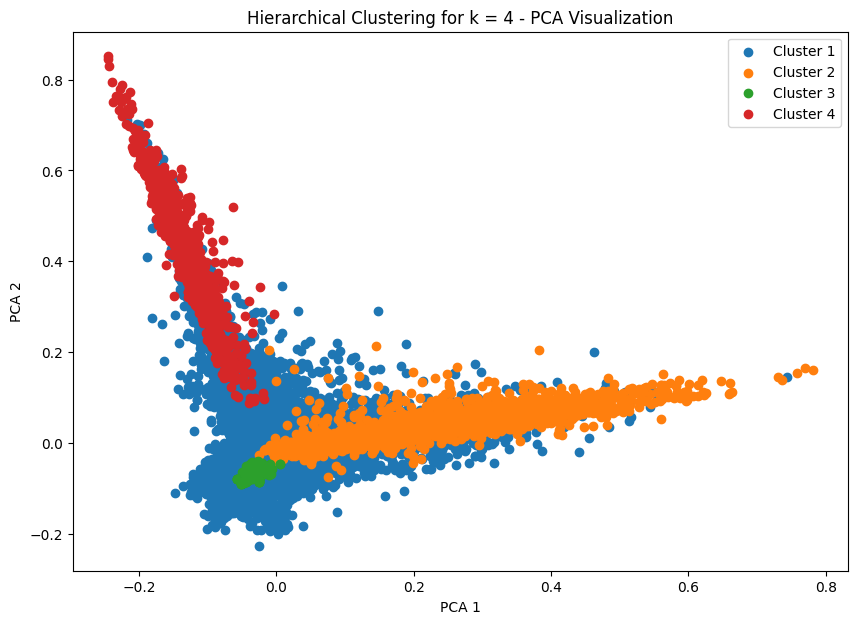

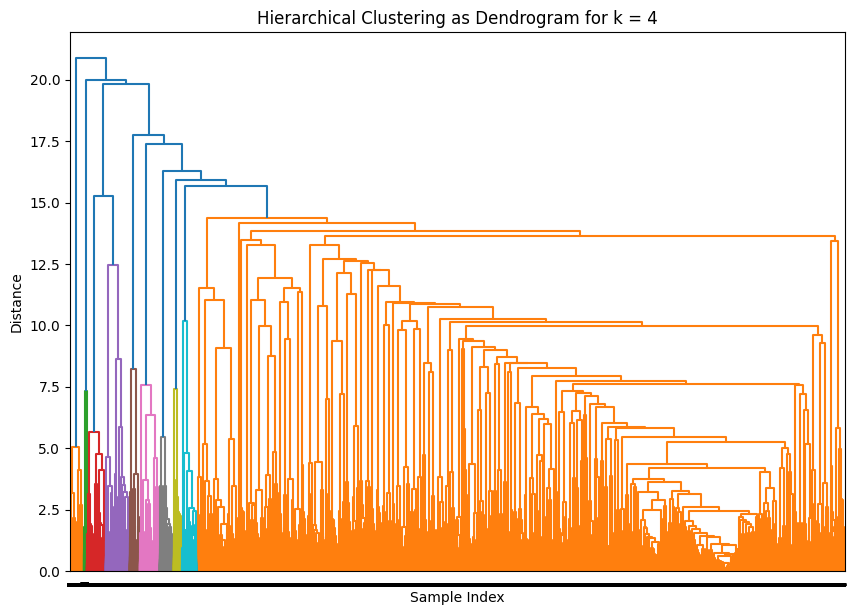

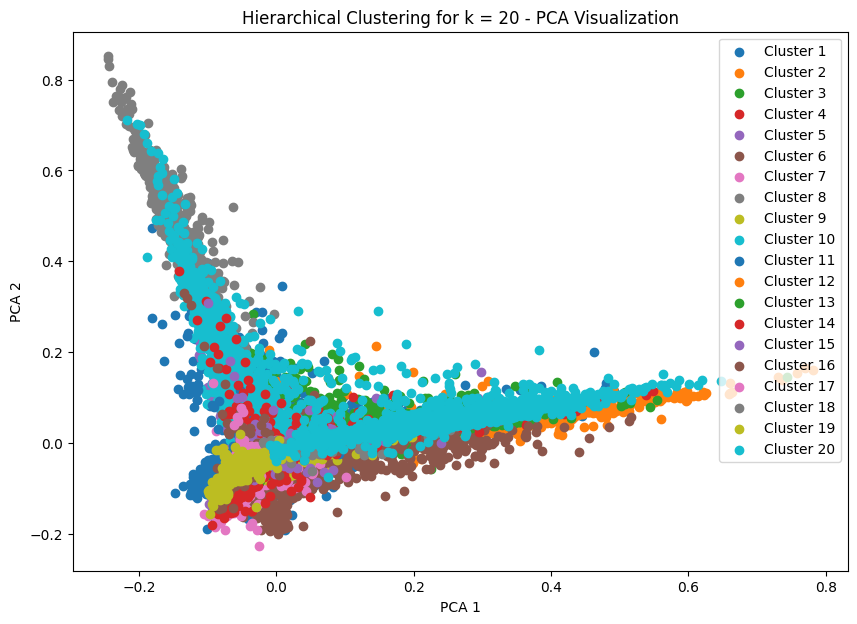

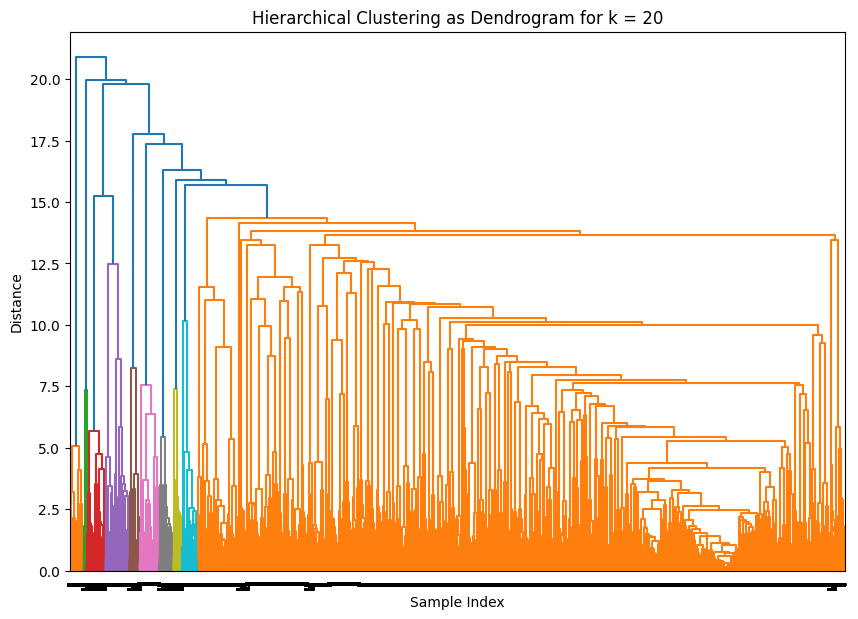

In [17]:
# Optimal value for k
optimal_k = [4, 20]

for k in optimal_k:
    # Perform Agglomerative Clustering
    agglo = AgglomerativeClustering(n_clusters=int(k), linkage='ward')
    labels = agglo.fit_predict(reduced_features)
    
    # PCA for visualizing the clusters
    pca_vis = PCA(n_components=2)
    pca_features = pca_vis.fit_transform(reduced_features)
    
    # Visualizing the clusters in the PCA space
    plt.figure(figsize=(10, 7))
    for i in range(int(k)):
        # Plot points from each cluster in the PCA space with different colors
        plt.scatter(pca_features[labels == i, 0], pca_features[labels == i, 1], label=f'Cluster {i+1}')
        
    plt.title(f'Hierarchical Clustering for k = {k} - PCA Visualization')
    plt.xlabel('PCA 1')
    plt.ylabel('PCA 2')
    plt.legend()
    plt.show()
    
    # Visualizing the dendrogram
    Z = linkage(reduced_features, 'ward')
    
    # Plotting the dendrogram
    plt.figure(figsize=(10, 7))
    dendrogram(Z, labels=labels)
    plt.title(f'Hierarchical Clustering as Dendrogram for k = {k}')
    plt.xlabel("Sample Index")
    plt.ylabel("Distance")
    plt.show()

# KMeans Visualization with PCA

Optimal_k 4 from silhouette and 20 from Elbow

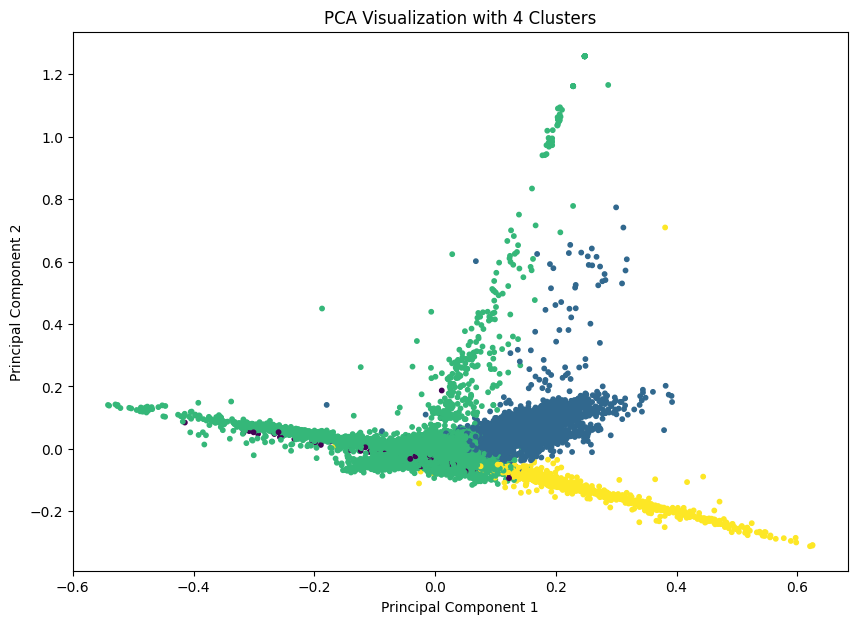

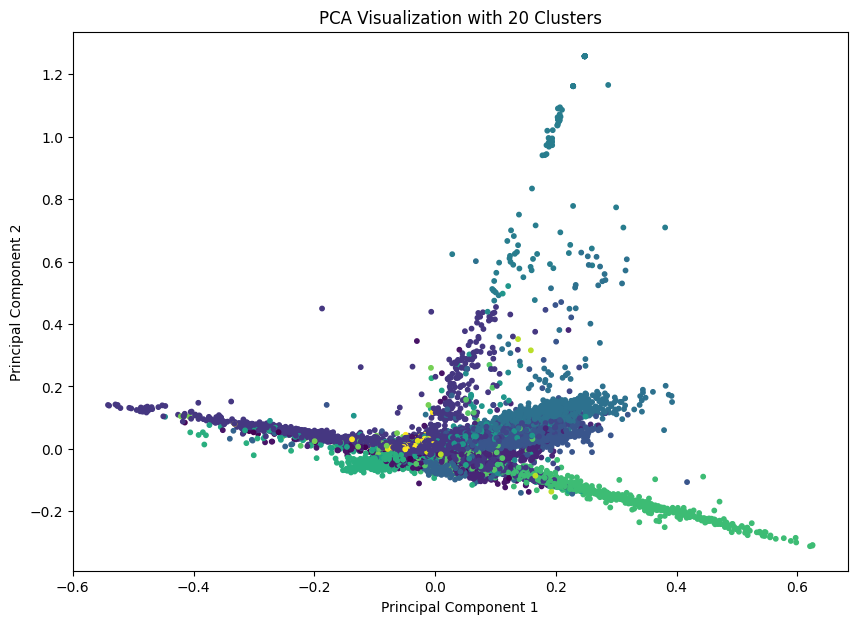

In [7]:
# Optimal value for k
optimal_k = [4, 20]

for k in optimal_k:
    kmeans = KMeans(n_clusters=int(k), random_state=42)
    news['cluster'] = kmeans.fit_predict(reduced_features)

    # PCA for Visualization
    pca_vis = IncrementalPCA(n_components=2)
    pca_features = pca_vis.fit_transform(reduced_features)
    
    # PCA Visualization
    plt.figure(figsize=(10, 7))
    plt.scatter(pca_features[:, 0], pca_features[:, 1], c=news['cluster'], cmap='viridis', s=10)
    plt.title(f'PCA Visualization with {k} Clusters')
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.show()

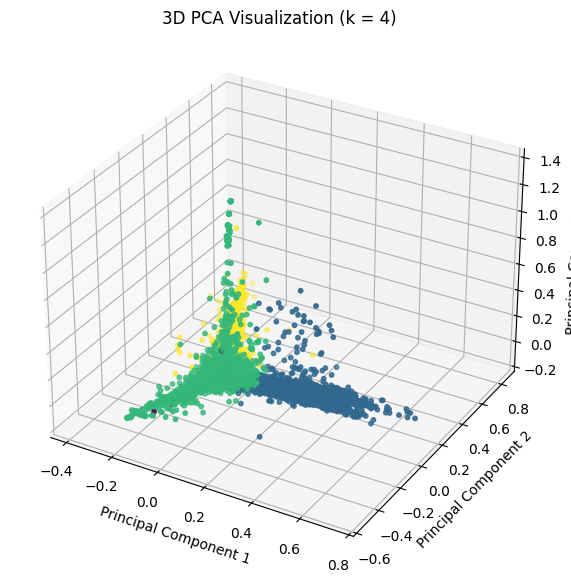

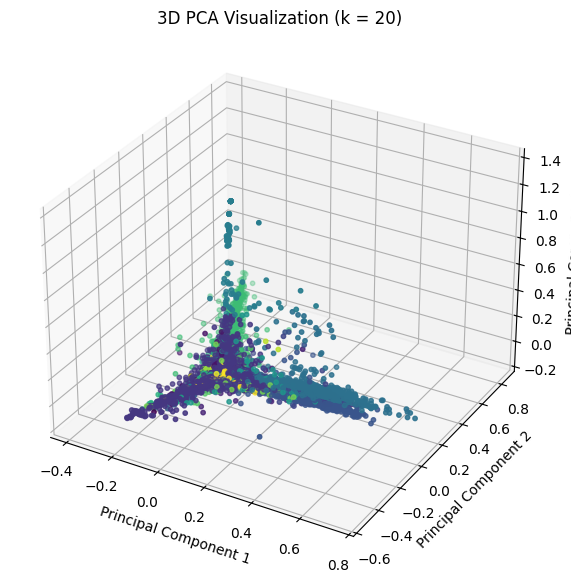

In [8]:
# PCA with 3 dimensions
optimal_k = [4, 20]

for k in optimal_k:
    kmeans = KMeans(n_clusters=int(k), random_state=42)
    news['cluster'] = kmeans.fit_predict(reduced_features)

    pca_3d = IncrementalPCA(n_components=3)
    pca_features_3d = pca_3d.fit_transform(reduced_features)
    
    # 3D-Visualisierung
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')
    scatter = ax.scatter(
        pca_features_3d[:, 0], 
        pca_features_3d[:, 1], 
        pca_features_3d[:, 2], 
        c=news['cluster'], cmap='viridis', s=10
    )
    
    ax.set_title(f'3D PCA Visualization (k = {k})')
    ax.set_xlabel('Principal Component 1')
    ax.set_ylabel('Principal Component 2')
    ax.set_zlabel('Principal Component 3')
    plt.show()

In [9]:
optimal_k = [4, 20]

for k in optimal_k:
    
    kmeans = KMeans(n_clusters=int(k), random_state=42)
    news['cluster'] = kmeans.fit_predict(reduced_features)
    
    # Print KMeans cluster centers
    print(f"KMeans Cluster Centers for k = {k}:")
    print(kmeans.cluster_centers_)
    
    # Print size of each cluster
    print(f"\nCluster Sizes for k = {k}:")
    for i in range(int(k)):
        print(f"Cluster {i}: {sum(news['cluster'] == i)} points")
    
    # Print inertia (sum of squared distances from samples to their cluster center)
    print(f"\nInertia (Within-cluster sum of squares) for k = {k}:")
    print(kmeans.inertia_)
    
    # Print explained variance ratio for the PCA components
    print(f"\nExplained Variance Ratio by PCA Components for k = {k}:")
    print(pca_vis.explained_variance_ratio_)

KMeans Cluster Centers for k = 4:
[[-5.92389671e-02 -6.41219987e-02  4.29578494e-03  2.43757637e-02
  -2.07611520e-03 -1.28213871e-01 -1.58570195e-01  5.56821668e-02
   6.15213435e-02 -1.34970279e-01 -2.68141555e-03 -2.76355375e-02
  -9.84461173e-03 -8.84451063e-02 -1.04803807e-01  7.50184070e-02
   2.99571476e-02 -7.54033098e-03  8.48333063e-03 -1.12160937e-02
   6.12645565e-03  1.42532895e-02 -1.00935993e-02 -2.10507967e-02
   2.23725055e-02  1.53055020e-02 -7.77851320e-03  2.75202408e-03
  -4.53342138e-04 -2.08790757e-03  1.27715924e-02  1.08635876e-02
  -2.00558605e-03  1.25451783e-03  4.02091980e-04 -7.99329890e-03
   9.40543840e-03  1.09461450e-02  4.72537459e-03 -3.53170112e-03
   1.32975139e-03 -1.49776232e-02 -7.76564812e-03  2.88230747e-03
   1.99519986e-03  2.79127145e-03 -5.56052390e-03 -2.32524895e-04
   1.28522710e-02 -3.99680752e-03 -3.76020334e-03  1.29730663e-03
   2.50221827e-05 -3.19999042e-03  1.52769421e-03 -9.36560156e-03
   4.31723390e-03  1.72386482e-03 -1.99183

In [10]:
# Analyse of the cluster centers: Find the most important words for each cluster
optimal_k = [4, 20]

for k in optimal_k:
    
    kmeans = KMeans(n_clusters=int(k), random_state=42)
    news['cluster'] = kmeans.fit_predict(reduced_features)
    
    print(f"KMeans most important words for k = {k}:")

    cluster_centers = kmeans.cluster_centers_
    
    # Display the most important words in each cluster
    terms = tfidf_vectorizer.get_feature_names_out()
    top_n = 10  # Show the top 10 most important words
    
    for i, center in enumerate(cluster_centers):
        top_indices = center.argsort()[-top_n:][::-1]  # Get the indices of the top_n words
        print(f"Cluster {i}:")
        for idx in top_indices:
            print(f"  {terms[idx]}: {center[idx]:.4f}")
            
    print("\n\n")        

KMeans most important words for k = 4:
Cluster 0:
  amid: 0.0750
  alive: 0.0615
  alabama: 0.0557
  analysis: 0.0300
  advantage: 0.0244
  announcement: 0.0224
  annual: 0.0153
  ankle: 0.0143
  arizona: 0.0129
  antonio: 0.0128
Cluster 1:
  abu: 0.2604
  adams: 0.0439
  african: 0.0219
  alive: 0.0183
  alabama: 0.0147
  apartment: 0.0060
  ameniti: 0.0055
  ann: 0.0054
  allegations: 0.0050
  anyth: 0.0048
Cluster 2:
  agent: 0.0046
  airport: 0.0043
  allegations: 0.0041
  americans: 0.0036
  american: 0.0029
  adoption: 0.0018
  amaz: 0.0016
  animal: 0.0010
  atlanta: 0.0007
  approv: 0.0006
Cluster 3:
  african: 0.3669
  agent: 0.0652
  airport: 0.0631
  alive: 0.0371
  alabama: 0.0193
  anniversary: 0.0187
  ankle: 0.0151
  ask: 0.0117
  anoth: 0.0098
  analysis: 0.0094



KMeans most important words for k = 20:
Cluster 0:
  animals: 0.2099
  anderson: 0.1110
  alive: 0.0624
  amid: 0.0599
  alabama: 0.0559
  analysis: 0.0394
  andrew: 0.0389
  antonio: 0.0289
  annual: 0.0287


Clusters 4 and 5 both focus on animal welfare, but one includes performance-related evaluations (analysis).

Clusters like 3, 6, and 7 have overlapping themes of services and facilities, but differ slightly (e.g., analysis, airport focus).

Clusters such as 12 and 16 involve alliances and advantages but are nuanced by controversies or partnerships.

In [11]:
# Frequency of categories and subcategories in each cluster
optimal_k = [4, 20]

for k in optimal_k:
    
    kmeans = KMeans(n_clusters=int(k), random_state=42)
    news['cluster'] = kmeans.fit_predict(reduced_features)
    
    print(f"KMeans: Frequency of categories ans subcategories for k = {k}:")

    category_counts = news.groupby(['cluster', 'category']).size().unstack().fillna(0)
    subcategory_counts = news.groupby(['cluster', 'subcategory']).size().unstack().fillna(0)
    
    print("Category distribution by cluster:")
    print(category_counts)
    print("\nSubcategory distribution by cluster:")
    print(subcategory_counts)
    
    print("\n\n")

KMeans: Frequency of categories ans subcategories for k = 4:
Category distribution by cluster:
category   autos  entertainment  finance  foodanddrink  health  kids  \
cluster                                                                
0            1.0            0.0      3.0           0.0     1.0   0.0   
1          371.0            7.0     18.0           7.0    10.0   0.0   
2         1245.0          557.0   3002.0        2483.0  1860.0  15.0   
3           20.0           15.0     61.0          44.0     5.0   1.0   

category  lifestyle  middleeast  movies  music     news  northamerica  \
cluster                                                                 
0               1.0         0.0     1.0    1.0      6.0           0.0   
1              33.0         0.0     4.0   12.0   2921.0           0.0   
2            2391.0         2.0   600.0  746.0  12608.0           1.0   
3              46.0         0.0     1.0    5.0    110.0           0.0   

category   sports  travel     tv 

In [13]:
from sklearn.feature_extraction.text import CountVectorizer

optimal_k = [4, 20]

for k in optimal_k:

    # Find the most common n-grams (2-3 word phrases) for each cluster
    vectorizer = CountVectorizer(ngram_range=(2, 3), stop_words='english', max_features=10)
    ngram_matrix = vectorizer.fit_transform(news['clean_title'] + " " + news['clean_abstract'])
    
    # Display n-grams for each cluster
    for i in range(int(k)):
        cluster_data = ngram_matrix[news['cluster'] == i]  # Get the n-gram data for each cluster
        sum_words = cluster_data.sum(axis=0)  # Sum the occurrences of each n-gram in the cluster
        sorted_words = sum_words.argsort()[::-1]  # Sort the words by their frequency
        feature_names = np.array(vectorizer.get_feature_names_out())  # Get the n-gram terms
        print(f"Cluster {i}:")
        for idx in sorted_words[:10]:  # Display the top 10 n-grams
            print(f"  {feature_names[idx]}")


Cluster 0:
  [['county sheriff' 'impeachment inquiry' 'president donald' 'police say'
  'st louis' 'white house' 'world seri' 'college football' 'high school'
  'kansas city']]
Cluster 1:
  [['college football' 'county sheriff' 'high school' 'kansas city'
  'police say' 'st louis' 'world seri' 'impeachment inquiry'
  'white house' 'president donald']]
Cluster 2:
  [['college football' 'impeachment inquiry' 'world seri'
  'president donald' 'white house' 'kansas city' 'st louis' 'police say'
  'county sheriff' 'high school']]
Cluster 3:
  [['president donald' 'county sheriff' 'police say' 'college football'
  'impeachment inquiry' 'white house' 'world seri' 'high school'
  'st louis' 'kansas city']]
Cluster 0:
  [['county sheriff' 'impeachment inquiry' 'president donald' 'police say'
  'st louis' 'white house' 'world seri' 'college football' 'high school'
  'kansas city']]
Cluster 1:
  [['college football' 'county sheriff' 'high school' 'kansas city'
  'police say' 'st louis' 'world ser

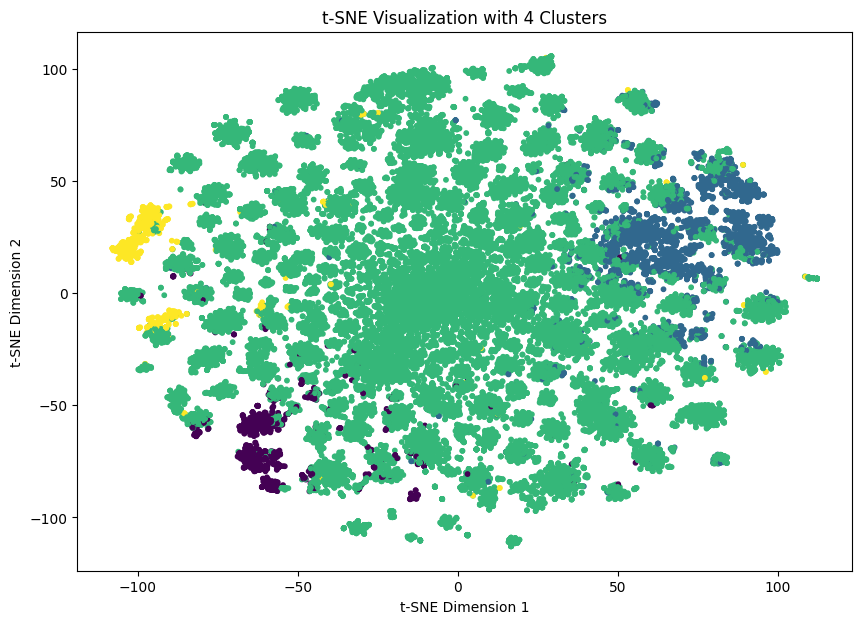

t-SNE Parameters:
Perplexity: 30
Number of iterations: deprecated

Cluster Sizes in t-SNE:
Cluster 0: 1344 points
Cluster 1: 3755 points
Cluster 2: 44563 points
Cluster 3: 1007 points


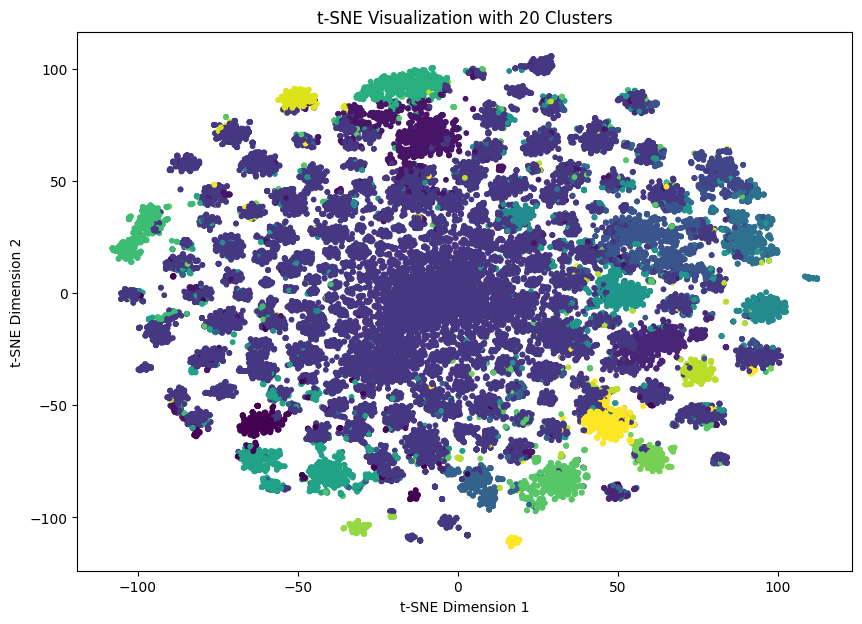

t-SNE Parameters:
Perplexity: 30
Number of iterations: deprecated

Cluster Sizes in t-SNE:
Cluster 0: 658 points
Cluster 1: 1809 points
Cluster 2: 1038 points
Cluster 3: 34061 points
Cluster 4: 705 points
Cluster 5: 1781 points
Cluster 6: 774 points
Cluster 7: 929 points
Cluster 8: 104 points
Cluster 9: 1044 points
Cluster 10: 1172 points
Cluster 11: 1529 points
Cluster 12: 913 points
Cluster 13: 805 points
Cluster 14: 1115 points
Cluster 15: 409 points
Cluster 16: 185 points
Cluster 17: 487 points
Cluster 18: 391 points
Cluster 19: 760 points


In [14]:
# t-SNE Transformation

optimal_k = [4, 20]

for k in optimal_k:
    
    kmeans = KMeans(n_clusters=int(k), random_state=42)
    news['cluster'] = kmeans.fit_predict(reduced_features)
    

    tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
    tsne_features = tsne.fit_transform(reduced_features)
    
    # t-SNE Visualization
    plt.figure(figsize=(10, 7))
    plt.scatter(tsne_features[:, 0], tsne_features[:, 1], c=news['cluster'], cmap='viridis', s=10)
    plt.title(f't-SNE Visualization with {k} Clusters')
    plt.xlabel('t-SNE Dimension 1')
    plt.ylabel('t-SNE Dimension 2')
    plt.show()
    
    # Print t-SNE parameters
    print("t-SNE Parameters:")
    print(f"Perplexity: {tsne.perplexity}")
    print(f"Number of iterations: {tsne.n_iter}")
    
    # Print size of each cluster in the t-SNE space
    print("\nCluster Sizes in t-SNE:")
    for i in range(int(k)):
        print(f"Cluster {i}: {sum(news['cluster'] == i)} points")


# DBSCAN Clustering

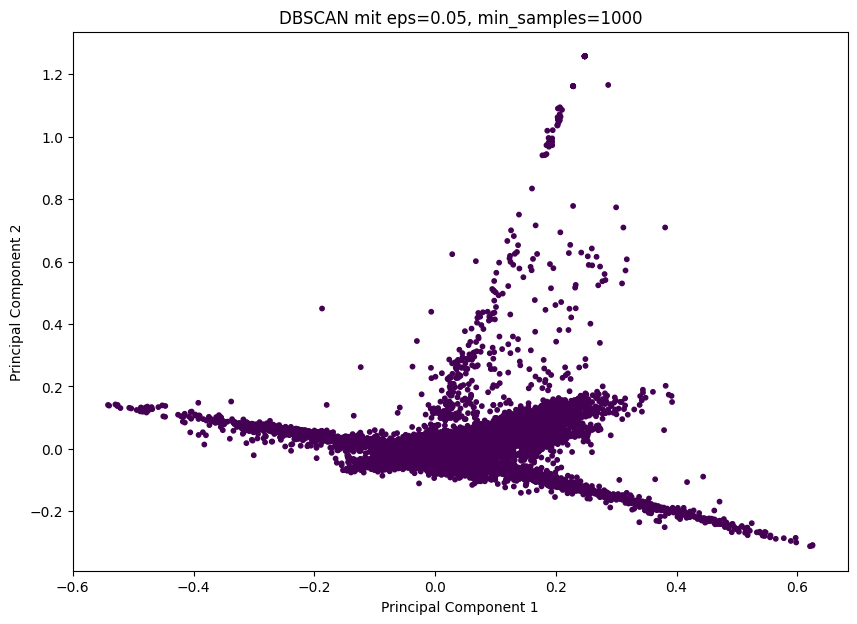

Parameter eps=0.05, min_samples=1000
{np.int64(-1): np.int64(50669)}

----------------------------------------



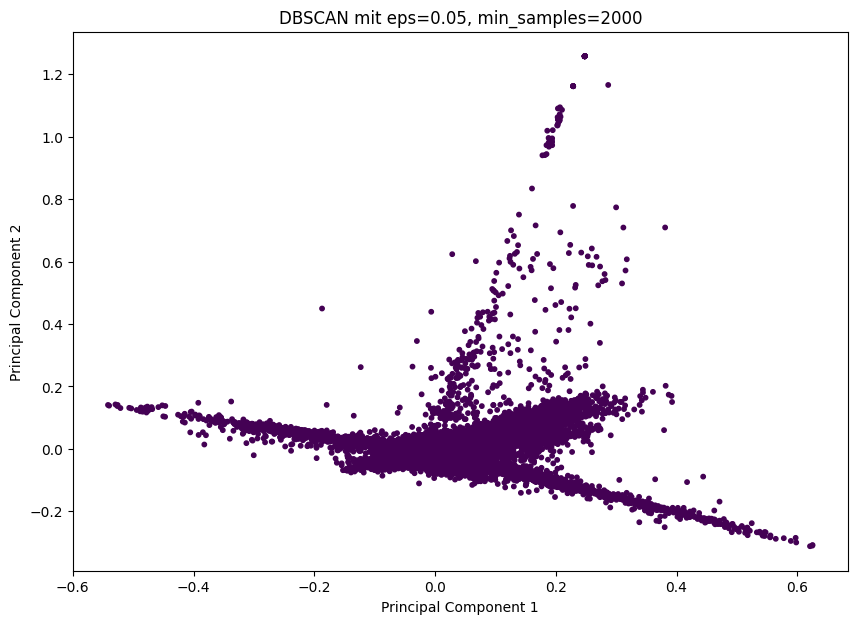

Parameter eps=0.05, min_samples=2000
{np.int64(-1): np.int64(50669)}

----------------------------------------



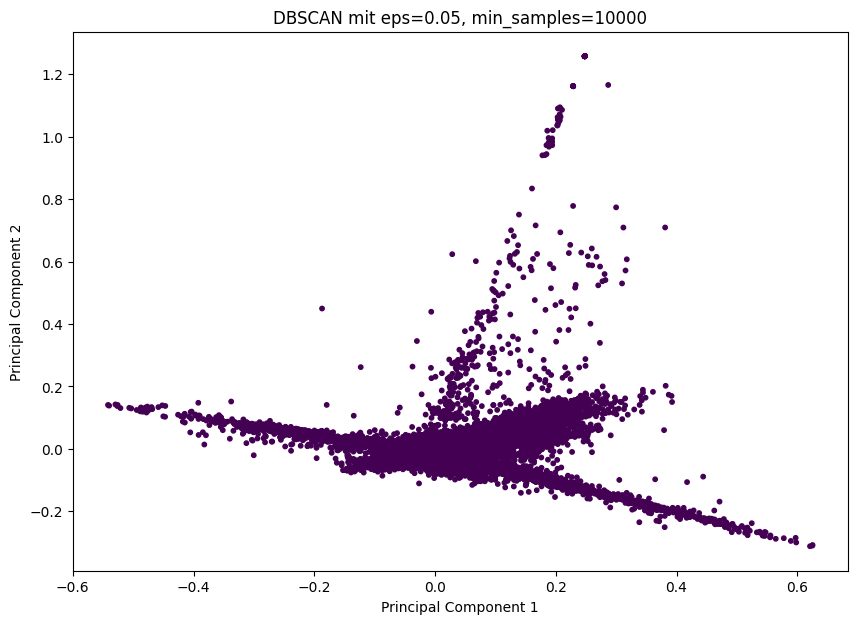

Parameter eps=0.05, min_samples=10000
{np.int64(-1): np.int64(50669)}

----------------------------------------



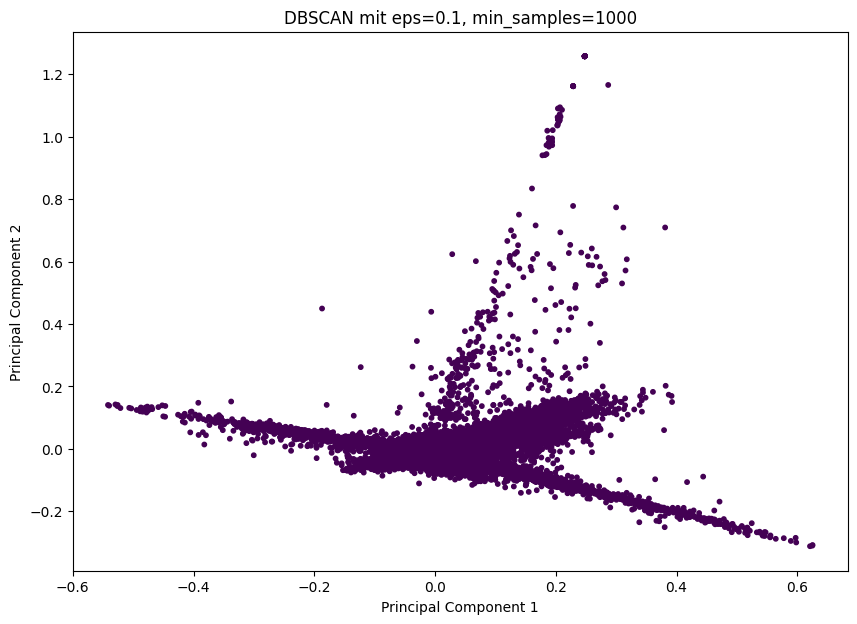

Parameter eps=0.1, min_samples=1000
{np.int64(-1): np.int64(50669)}

----------------------------------------



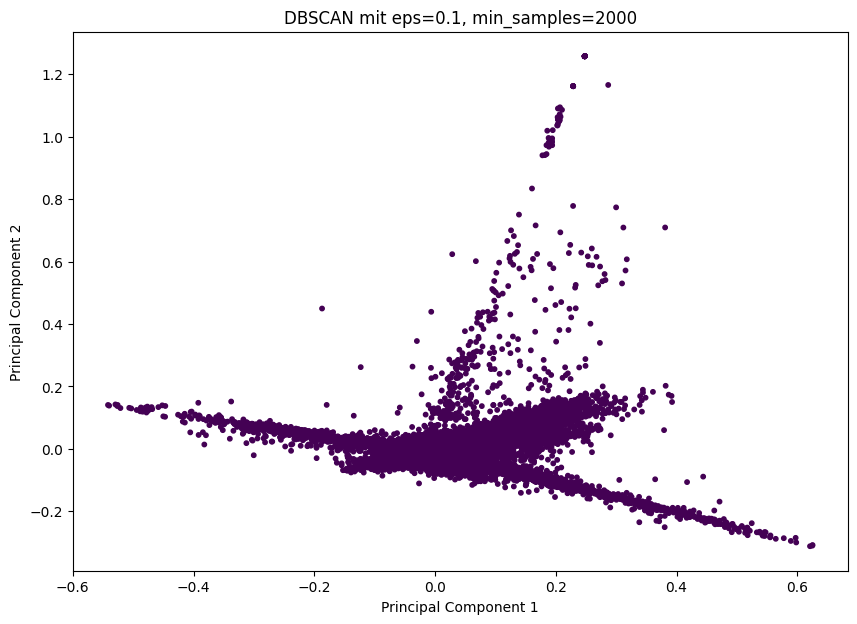

Parameter eps=0.1, min_samples=2000
{np.int64(-1): np.int64(50669)}

----------------------------------------



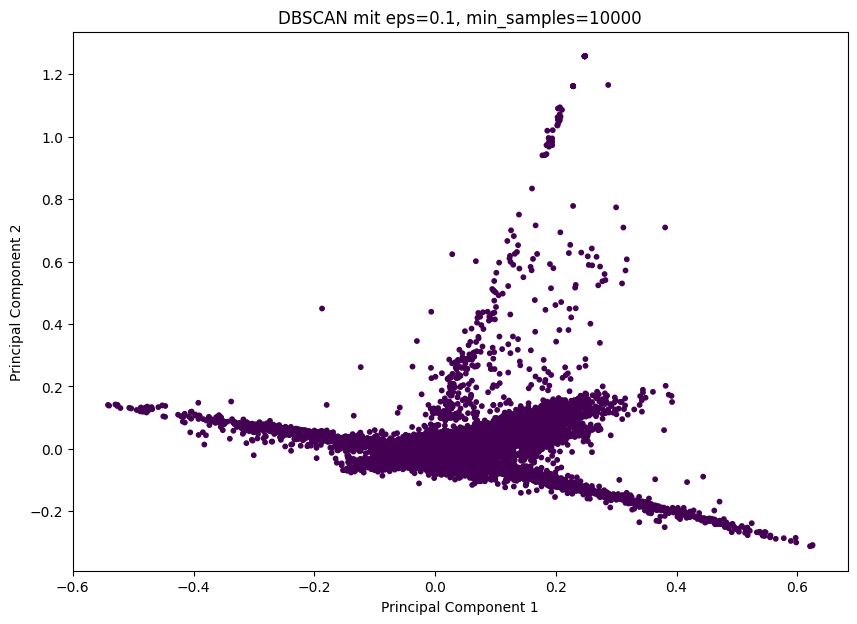

Parameter eps=0.1, min_samples=10000
{np.int64(-1): np.int64(50669)}

----------------------------------------



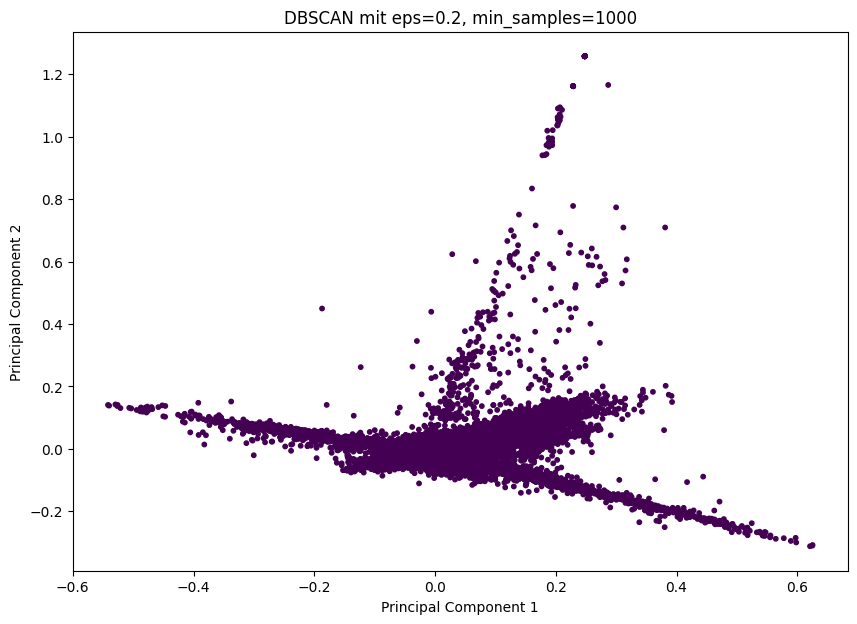

Parameter eps=0.2, min_samples=1000
{np.int64(-1): np.int64(50669)}

----------------------------------------



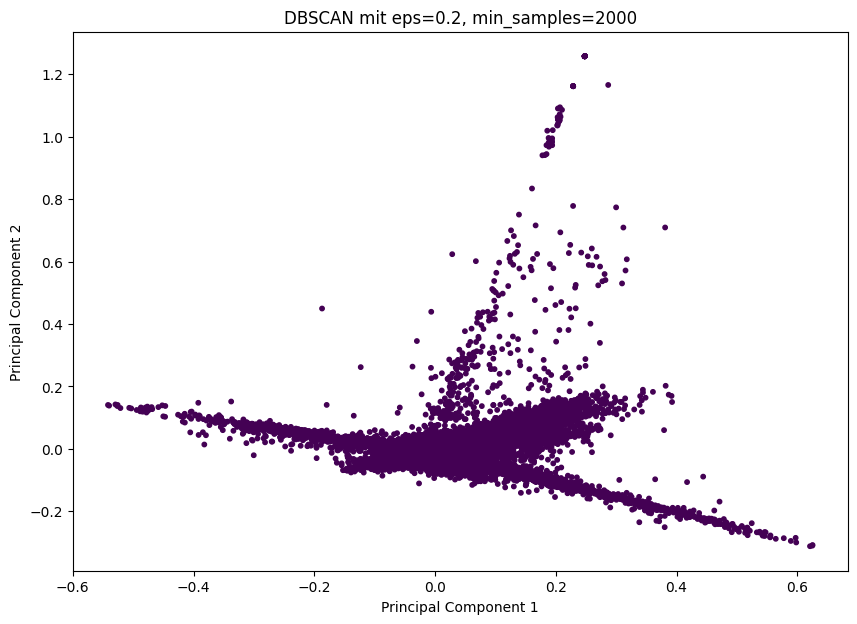

Parameter eps=0.2, min_samples=2000
{np.int64(-1): np.int64(50669)}

----------------------------------------



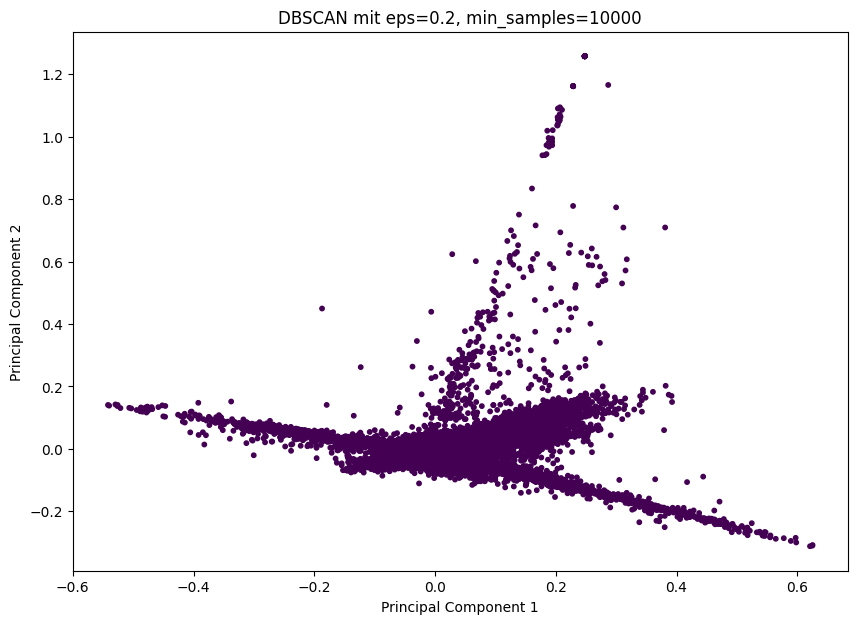

Parameter eps=0.2, min_samples=10000
{np.int64(-1): np.int64(50669)}

----------------------------------------



In [15]:
# DBSCAN Clustering
eps_values = [0.05, 0.1, 0.2]
min_samples_values = [1000, 2000, 10000]

# Small eps values (like 0.05) lead to many small, dense clusters and a high number of outliers, which might be too restrictive for your dataset.
# Medium eps values (e.g., 0.1) offer a better balance and create several larger clusters. This might be a better choice as it results in fewer outliers and more differentiated clusters.
# Large eps values (e.g., 0.2) tend to group most data points into one cluster, indicating that eps=0.2 is too large to form meaningful clusters.

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples, metric='cosine')
        labels = dbscan.fit_predict(reduced_features)

        plt.figure(figsize=(10, 7))
        plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', s=10)
        plt.title(f'DBSCAN mit eps={eps}, min_samples={min_samples}')
        plt.xlabel('Principal Component 1')
        plt.ylabel('Principal Component 2')
        plt.show()

        unique, counts = np.unique(labels, return_counts=True)
        print(f'Parameter eps={eps}, min_samples={min_samples}')
        print(dict(zip(unique, counts)))
        print("\n" + "-"*40 + "\n")

# Elements an Categories per Clustering

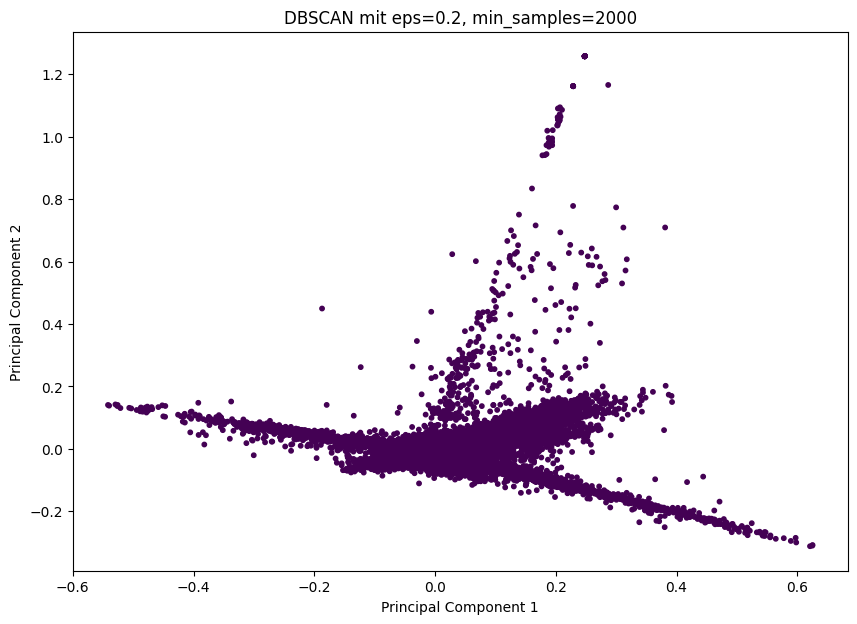

Parameter eps=0.2, min_samples=2000
{np.int64(-1): np.int64(50669)}

----------------------------------------

Number of articles per DBSCAN cluster:
{np.int64(-1): np.int64(50669)}

Cluster -1:
Examples:
                                               title       category
0  The Brands Queen Elizabeth, Prince Charles, an...      lifestyle
1                      50 Worst Habits For Belly Fat         health
2  The Cost of Trump's Aid Freeze in the Trenches...           news
3  I Was An NBA Wife. Here's How It Affected My M...         health
4  How to Get Rid of Skin Tags, According to a De...         health
5  Should NFL be able to fine players for critici...         sports
6  It's been Orlando's hottest October ever so fa...        weather
7  Chile: Three die in supermarket fire amid prot...           news
8  Best PS5 games: top PlayStation 5 titles to lo...  entertainment
9     How to report weather-related closings, delays           news

Categories in the cluster:
category
news      

In [16]:
# DBSCAN
best_eps = 0.2
best_samples = 2000


dbscan = DBSCAN(eps= best_eps, min_samples=best_samples, metric='cosine')
labels = dbscan.fit_predict(reduced_features)

plt.figure(figsize=(10, 7))
plt.scatter(pca_features[:, 0], pca_features[:, 1], c=labels, cmap='viridis', s=10)
plt.title(f'DBSCAN mit eps={best_eps}, min_samples={best_samples}')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

unique, counts = np.unique(labels, return_counts=True)
print(f'Parameter eps={best_eps}, min_samples={best_samples}')
print(dict(zip(unique, counts)))
print("\n" + "-"*40 + "\n")


# Count the number of articles in each DBSCAN cluster
unique_labels = np.unique(labels)  # labels = DBSCAN output labels
cluster_counts_dbscan = {label: (labels == label).sum() for label in unique_labels}

# Initialize dictionaries to store cluster information
cluster_examples_dbscan = {}
cluster_categories_dbscan = {}

# Iterate through each DBSCAN cluster
for cluster_id in unique_labels:
    cluster_data = news[labels == cluster_id]
    
    # Save 10 example articles (title and category)
    cluster_examples_dbscan[cluster_id] = cluster_data[['title', 'category']].head(10)
    
    # Count the categories within the cluster
    cluster_categories_dbscan[cluster_id] = cluster_data['category'].value_counts()

# Print the results
print("Number of articles per DBSCAN cluster:")
print(cluster_counts_dbscan)

for cluster_id in cluster_examples_dbscan:
    print(f"\nCluster {cluster_id}:")
    print("Examples:")
    print(cluster_examples_dbscan[cluster_id])
    print("\nCategories in the cluster:")
    print(cluster_categories_dbscan[cluster_id])

# Recommendation

For the recommendation the first thing is to save the user histories to a dataframe to append the clusters. For the clusters the kmeans results are used and each article in the user history get the resulting cluster. 
After that the top cluster is being obtained by counting all the clusters and pick the one with the highest count.
For the recommendation a user_id is provided, then the top cluster gets evaluated and the top 10 articles within this cluster will be recommended to the user. Within this process the articles that the user alread read are being filterd out.

In [ ]:
# Split 'history' into lists of baskets based on ids
# Group by user and get rid of duplicates in the history
user_histories = []
user_data_for_df = []
for user_id, user_data in behaviors.groupby('user_id'):
    one_history_string = " ".join(user_data['history'])
    splitted_without_duplicates = set(one_history_string.split())
    articles_list_per_user = list(splitted_without_duplicates)
    user_histories.append(articles_list_per_user)
    user_data_for_df.append([user_id, articles_list_per_user])

# Generate dictionary for handeling the article titles
news_title_dict = dict(zip(news['news_id'], news['title']))

In [ ]:
# Clustering with KMeans
optimal_k = 20

kmeans = KMeans(n_clusters=optimal_k, random_state=42)
news['cluster'] = kmeans.fit_predict(reduced_features)

# Count occurence of each article
articles_count = {}

for history in user_histories:
    for article in history:
        if article in articles_count:
            articles_count[article] += 1
        else:
            articles_count[article] = 1

# Append cluster to articles count and sort clusters from higehst to lowest
cluster_dict = defaultdict(list)
for _, row in news.iterrows():
    news_id = row['news_id']
    cluster = row['cluster']
    
    if news_id in articles_count:
        cluster_dict[cluster].append((articles_count[news_id], news_id))

for cluster in cluster_dict:
    cluster_dict[cluster] = sorted(cluster_dict[cluster], key=lambda x: x[0], reverse=True)

top_sorted_articles = {}

for cluster, articles in cluster_dict.items():
    top_sorted_articles[cluster] = [news_id for _, news_id in articles]

# Create Dataframe for dealing with top cluster per user
user_histories_df = pd.DataFrame(user_data_for_df, columns=['user_id', 'full_history'])
user_histories_df = behaviors[['user_id']].drop_duplicates().merge(user_histories_df, on='user_id')

# Get cluster for every article in user history
user_histories_df["clusters"] = None
news_dict = dict(zip(news["news_id"], news["cluster"]))

for idx, row in user_histories_df.iterrows():
    user_id = row['user_id']
    full_history = row['full_history']
    cluster_list = []
    for article in full_history:
        if article in news_dict:
            cluster_list.append(news_dict[article])
    user_histories_df.at[idx, "clusters"] = cluster_list

# Count top cluster per user
for idx, row in user_histories_df.iterrows():
    cluster_counts = {}
    clusters = row['clusters']
    if clusters != []:
        for cluster in clusters:
            cluster_counts[cluster] = cluster_counts.get(cluster, 0) + 1
        if cluster_counts:
            top_cluster = max(cluster_counts, key=cluster_counts.get)
    else:
        top_cluster = None
    user_histories_df.at[idx, "top_cluster"] = top_cluster
user_histories_df["top_cluster"] = user_histories_df["top_cluster"].astype("Int64")

# Print occurence of top clusters
value_counts = user_histories_df["top_cluster"].value_counts().sort_index()
print(value_counts)

# Get top cluster and recommend top 10 articles (that haven't been read)
# Print recommendations

user_id = "U13740"
user_top_cluster = user_histories_df[user_histories_df["user_id"] == user_id]["top_cluster"].iloc[0]
user_history = user_histories_df[user_histories_df["user_id"] == user_id]["full_history"].iloc[0]

top_articles_from_cluster = top_sorted_articles[int(user_top_cluster)]

recommend_list = []
count = 0
for top_article in top_articles_from_cluster:
    if top_article not in article:
        recommend_list.append(top_article)
        count += 1
    if count == 10:
        break

print("User ID: ", user_id)
print("Top Cluster: ", user_top_cluster)
print("What user have read so far:")
print(user_history, "\n")
print("Recommendation for user:")
recommend_list_text = []
for article in recommend_list:
    title = str(article) + ": " + str(news_title_dict[article])
    recommend_list_text.append(title)
    print(title)